# Tree tomography - December 17, 2023

This covers the first day's data taken from a cedar log (aka "The Log o' Science").

In [1]:
from datetime import datetime, timedelta
import json
import pytz

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
# import scipy
import scipy.stats as st
# pd.set_option('max_columns', 50)

mpl.style.use('ggplot')

%matplotlib inline

# Today's data

- no holes: the log in its original condition.
- one hole: the log with one 1" (2.54 cm) hole drilled out in the middle.
- three holes: the log with that 1" hole extended on either side; total length ~ 2.75", total depth ~ 3.5"
- three holes, second time: after moving the protective board for sensor 1 so now poking up above log level -- hopefuly to get more consistent hit from hammer
- Files edited to remove outliers (values in 10s or 100s of thousands of microseconds)

TODO: Add pictures


In [2]:
df = pd.DataFrame()
# Note: there are more values for the three_holes file.  We'll read this in first 
# so we don't have everything clamped to the shorter length of the no_holes file,
# but then we'll swap things around.
df["three_holes"] = pd.read_csv("third_run_1_to_2.csv", header=None)
df["one_hole"] = pd.read_csv("second_run_1_to_2.csv", header=None)
df["no_holes"] = pd.read_csv("first_run_1_to_2.csv", header=None)

cols = list(df.columns)
cols.reverse()
df = df[cols]
df["three_holes_second_time"] = pd.read_csv("2023-12-17_15:40:39.csv", header=None)

df

,no_holes,one_hole,three_holes,three_holes_second_time
0,421.18,701.76,697.00,751.28
1,698.22,714.18,464.00,723.32
2,694.68,695.54,1609.88,737.48
3,725.82,728.60,482.98,732.56
4,1356.54,709.28,706.30,711.70
5,690.90,690.30,485.18,611.94
6,685.12,704.42,1689.60,754.40
7,684.58,699.66,920.80,1652.38
8,689.44,699.90,1596.14,612.98
9,1350.10,692.18,698.22,764.86


In [3]:
def get_mean_and_std_in_cluster(df: pd.DataFrame, col: str, min: float, max: float) -> (float, float):
    """Get the mean of a column in df where its 
    values are between min and max.

    Helpful for getting the mean of a cluster, 
    rather than the mean of the whole column.

    Args:
      df: dataframe
      col: name of column in dataframe
      min: min range
      max: max range

    Returns:
      tuple(float, float): mean and stddev of values in that range
    """
    idx = df[col].between(min, max, inclusive="both")
    # print(idx)
    return (
        df[col][idx].mean(),
        df[col][idx].std(),
    )
    
print(get_mean_and_std_in_cluster(df, "no_holes", 600, 800))
print(get_mean_and_std_in_cluster(df, "one_hole", 600, 800))
print(get_mean_and_std_in_cluster(df, "three_holes", 600, 800))
print(get_mean_and_std_in_cluster(df, "three_holes_second_time", 600, 800))

(692.018125, 8.330817036761761)
(700.6917073170731, 10.658549597022812)
(694.1962962962963, 23.984223043195602)
(725.517894736842, 42.5776659736778)


In [4]:
def get_confidence_interval(df, col):
    """Get confidence interval for col in df.
    """
    mean, std = get_mean_and_std_in_cluster(df, col, 600.0, 800.0)
    crange_extremes = st.norm.interval(0.95, loc=mean, scale=std)
    crange = (crange_extremes[1] - crange_extremes[0]) / 2
    print(f"{mean} +/- {crange/2}")

get_confidence_interval(df, "no_holes")

692.018125 +/- 8.164050676922898


Note: that confidence interval does not line up with this tool: https://www.omnicalculator.com/statistics/confidence-interval

That one takes into account population size.

See also: https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Foundations_in_Statistical_Reasoning_(Kaslik)/06%3A_Confidence_Intervals_and_Sample_Size

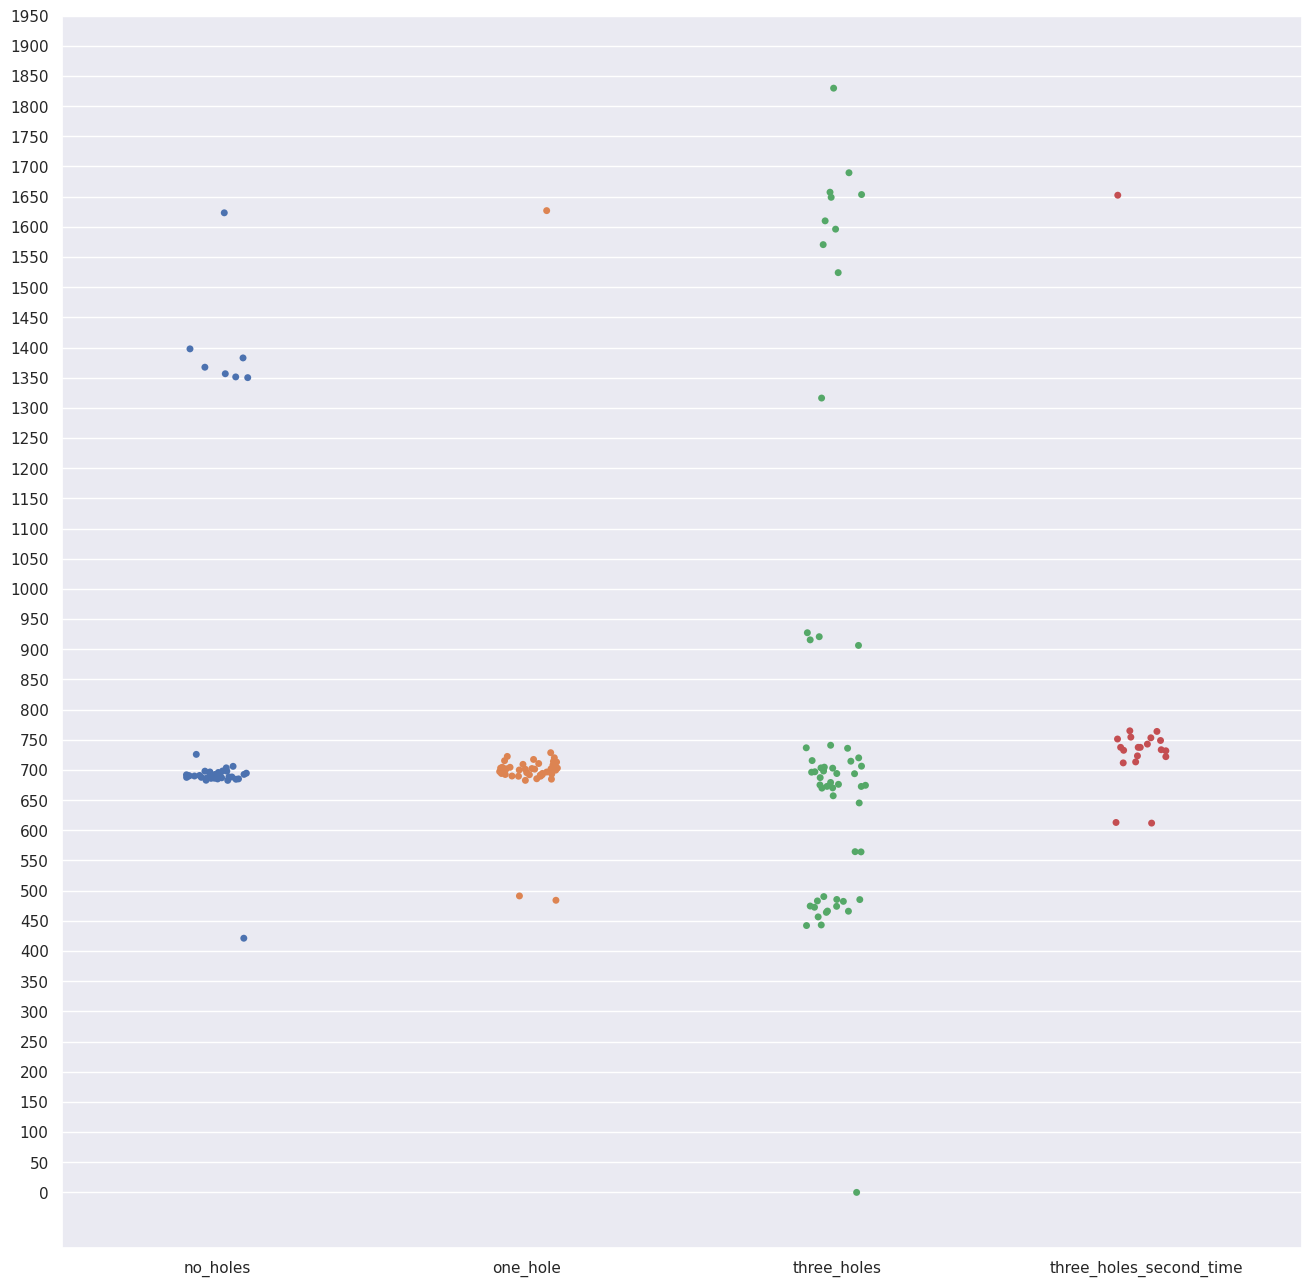

In [5]:
[x for x in range(0, 2000, 50)]
sns.set(rc={"figure.figsize":(16, 16)}) #width=8, height=4

line_plot = sns.stripplot(data=df) # .set(title="Sensor 1 -> 2 in Log o' Science", ylabel="microseconds")
plt.yticks([y for y in range(0, 2000, 50)])
fig = line_plot.get_figure()
fig.savefig('my_lineplot.png')

In [6]:
df.std()

no_holes                   283.187950
one_hole                   148.434534
three_holes                405.175041
three_holes_second_time    211.355417
dtype: float64

# First impressions
* The spread in the three hole data is quite obvious.
* It's interesting to see the data between 400 & 500 microseconds:
  * one value for no holes, one hole
  * a dozen or more for three holes
* Same is true for 1500-1800 microseconds, though that ignores the 1350-1400 microsecond cluster in no hole data.
* Need more data!
  * There was a certain amount of moving/changing things.
  * The hammer was resting on the board; it should be stood up beside it.
  * Wonder if the single value clusters in no holes/one holes would have been multiple values if I'd got, say, 100 hits each.
* I *really* wonder what's going on with the clustering.

Suggestion from a coworker: how is the three hole data distributed through time?  Is there something about the testing rig that might change over time?  Do all the large values come toward the beginning or end of the run?

<Axes: ylabel='three_holes'>

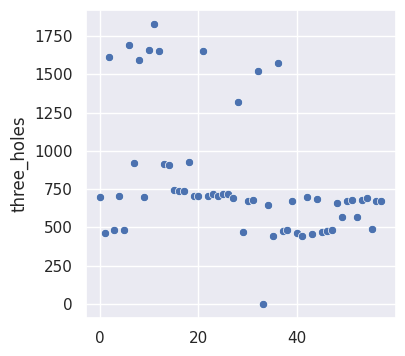

In [7]:
sns.set(rc={"figure.figsize":(4, 4)})
sns.scatterplot(data=df["three_holes"])

Hm -- sure is something about the 40th-50th sample that make it look like it quieted down.

It was also suggested that I could try clustering the data with kmeans, so let's see if I can give that a try.

In [11]:
from scipy.cluster.vq import kmeans, whiten

def kmeans_onecol(df: pd.DataFrame, col: str):
    """Do kmeans on just one column"""
    vals = df[df[col].isnull() == False][col]
    whitened = whiten(vals)
    codebook, distortion = kmeans(whitened, 2)
    print(codebook)
    plt.scatter(whitened, whitened)
    plt.scatter(codebook, codebook, c='r')
    plt.show()

[ 4.70759038 11.08669242]


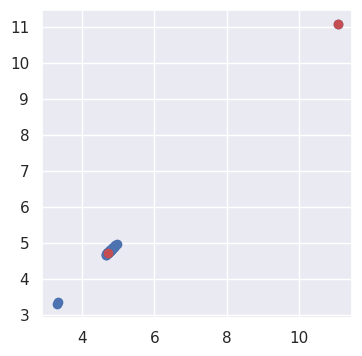

In [12]:
kmeans_onecol(df, "one_hole")

Hm.  A couple things:

- this is worth investigating as a way to group plots.
- picked scipy method randomly.  how does this compare w/sklearn?
- how do I plot bounding box around group?
- not sure I understand at all how to do 2d kmeans clustering with my data.

# Is this data normally distributed?

I'd like to figure out if the data is normally distributed.  Let's plot some histograms.

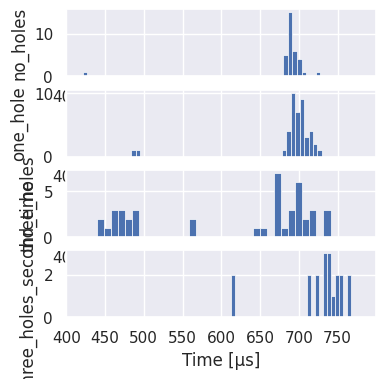

In [47]:
# plot:
fig, ax = plt.subplots(4, 1)
fig.suptitle = "No holes"

lower, upper = 400, 800

# TODO: What's that python trick where you
i = 0
for col in list(df.columns):
    ax[i].hist(df[col], bins=200, linewidth=0.5, edgecolor="white")
    ax[i].set(xlim=(lower, upper), xticks=np.arange(lower, upper, 50))
    ax[i].set_xlabel('Time [μs]')
    ax[i].set_ylabel(col)
    i += 1

plt.show()

Interesting -- no hole & one hole looks pretty close to normal distribution. Three holes (both) do not.  

More data more better, but maybe one hypothesis is:

- with no holes, we're taking a direct path; thus, normal, since we're taking measurements of one thing.
  - one hole: maybe we have *mostly* one path?  Like, it's not enough to seriously deflect things?
- with three holes, now we have a serious obstacle; thus, we have multiple paths through, and there are lots of things we're measuring.

